In [451]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd


In [452]:
data = pd.read_csv("./diabetic_data.csv")
data.replace('?',np.nan,inplace=True)

In [459]:
from math import log10
class ExploratoryDataAnalysis:
    def __init__(self,data):
        self.data = data
    
    def get_feature_class_count(self,col):
        count_map = {}
        for x in col:
            if(x in count_map):
                count_map[x] = count_map[x] + 1
            else:
                count_map[x] = 1

        return log10(len(count_map))
    
    def get_missing_counts(self,col):
        return len(col) - col.count()
    
    def plot_class_counts(self,plot_missing_feature_count = False):
        class_counts = [self.get_feature_class_count(self.data[column]) for column in self.data]
        data = [go.Histogram(x=self.data.columns, y=class_counts)]
        trace = go.Bar(
            x=self.data.columns,
            y=class_counts
        )
        layout = go.Layout(
            title='Feature counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace], layout=layout))
    
    def plot_class_count(self):
        count_NO = 0
        count_less_30 = 0
        for x in self.data["readmitted"]:
            if(x == "NO"):
                count_NO = count_NO + 1
            elif (x == "<30"):
                count_less_30 = count_less_30 + 1

        trace = go.Bar(
            x=[">30","<30","NO"],
            y=[(len(self.data) - count_NO  - count_less_30),count_less_30,count_NO]
        )
        layout = go.Layout(
            title='Class counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace], layout=layout))
        
    def plot_missing_count(self):
        class_counts = [len(self.data[column]) for column in self.data]
        missing_counts = [self.get_missing_counts(self.data[column]) for column in self.data]
        data = [go.Histogram(x=self.data.columns, y=class_counts)]
        trace = go.Bar(
            x=self.data.columns,
            y=class_counts
        )
        trace_missing = go.Bar(
            x=self.data.columns,
            y=missing_counts
        )
        layout = go.Layout(
            title='Feature counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace,trace_missing], layout=layout))
        

    

In [460]:
EDA = ExploratoryDataAnalysis(data)
EDA.plot_class_counts()
EDA.plot_class_count()
EDA.plot_missing_count()

In [448]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack,vstack

    
class OneHotEncoderWithFeaturePrunning:
    def __init__(self,threshold_count=50,dummy_variable="UNK"):
        self.enc = CountVectorizer(analyzer='char_wb',lowercase=False)
        self.frequency_map = {}
        self.threshold_count = threshold_count
        
        
    def fit(self,data):
        map(self._process_frequencies,enumerate(data))
        map(self._process_rare_data,enumerate(data))
        return self.enc.fit(data)
        
    def _process_frequencies(self,data,index):
        if(data[index] not in self.frequency_map):
            self.frequency_map[data[index]] = 1
        else:
            self.frequency_map[data[index]] = self.frequency_map[data[index]] + 1
            
    def _process_rare_data(self,data,index):
        if(self.frequency_map[data[index]] <= self.threshold_count):
            data[index] = self.dummy_variable
            
    def fit_transform(self,data):
        map(self._process_frequencies,enumerate(data))
        map(self._process_rare_data,enumerate(data))
        return self.enc.fit_transform(data)
    
    def transform(self,data):
        map(self._process_rare_data,enumerate(data))
        return self.enc.transform(data)
            
    def get_encoder(self):
        return self.enc
    
class FeatureEngineering:
       
    def get_encoding(self,column):
        categorical_encoder = OneHotEncoderWithFeaturePrunning()
        return categorical_encoder.fit_transform(column.astype('str')), categorical_encoder
    
    def fit(self,data,y):
        self.categorical_indices={
            "race":True,
            "gender": True,
            "age":True,
            "admission_type_id":True,
            "discharge_disposition_id":True,
            "admission_source_id": True,
            "time_in_hospital": False,
#             "medical_specialty":True,
            "num_lab_procedures":False,
            "num_procedures":False,
            "num_medications":False,
            "number_outpatient":True,
            "number_emergency":True,
            "number_inpatient":True,
            "diag_1":True,
            "diag_2":True,
            "diag_3":True,
            "number_diagnoses":False,
            "max_glu_serum":True,
            "A1Cresult":True,
            "metformin":True,
            "repaglinide":True,
            "nateglinide":True,
            "chlorpropamide":True,
            "glimepiride":True,
            "acetohexamide":True,
            "glipizide":True,
            "glyburide":True,
            "tolbutamide":True,
            "pioglitazone":True,
            "rosiglitazone":True,
            "acarbose":True,
            "miglitol":True,
            "troglitazone":True,
            "tolazamide":True,
#             "examide":True,
#             "citoglipton":True,
            "insulin":True,
            "glyburide-metformin":True,
            "glipizide-metformin":True,
            "metformin-rosiglitazone":True,
            "metformin-pioglitazone":True,
            "change":True,
            "diabetesMed":True
        }
        x = None
        self.encoder = {}
        for label, column in data.items():
            if(label in self.categorical_indices):
                if(self.categorical_indices[label] == True):
                    encoded_data,self.encoder[label] = self.get_encoding(column)
                    x = encoded_data if x == None else hstack([x,encoded_data],format="csr")
                else:
                    x = column if x == None else hstack([x,((pd.DataFrame(column.astype('float64'))).to_sparse())],format="csr")
        return x
    
    def fit_transform(self,data,y):
        return self.fit(data,y)
    
    def transform(self,data):
        x = None
        for label, column in data.items():
            if(label in self.categorical_indices):
                if(self.categorical_indices[label] == True):
                    encoded_data = (self.encoder[label]).transform(column.astype('str'))
                    x = encoded_data if x == None else hstack([x,encoded_data])
                else:
                    x = column if x == None else hstack([x,(pd.DataFrame(column).to_sparse())])
        return x
    

In [479]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
# from sklearn.externals import funcsigs as signature
from sklearn.metrics import average_precision_score

def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,2), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# def print_prauc(y_test,y_score):
#     average_precision = average_precision_score(y_test, y_score)

#     print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision))
#     precision, recall, _ = precision_recall_curve(y_test, y_score)

#     # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
#     step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
#     plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
#     plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))
#     plt.show()

    
def print_raoc(y_test,y_score):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
def print_result(y_test1, y_pred1, y_pred_proba1=0):
    cm = confusion_matrix(y_test1, y_pred1, labels=[0,1,2])
    print_confusion_matrix(cm, [0, 1, 2])
    print(classification_report(y_test1, y_pred1))
    
from sklearn.metrics import confusion_matrix, classification_report
def generate_results(clf,X_test,y_test):
    print(X_test.shape[1])
    pred = clf.predict(X_test)
    print_result(y_test, pred)
    score = clf.decision_function(X_test)
#     print_prauc(y_test, score)
#     print_raoc(y_test, score)

In [495]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
def split_data(x,label):
    X_train, X_test, y_train, y_test = train_test_split(x, label, test_size=0.20)
    return X_train, X_test, y_train, y_test

y = (data["readmitted"].astype('str')).apply(lambda x: 0 if x == "NO" else (1 if x == "<30" else 2))
X_train, X_test, y_train, y_test = split_data(data,y) 
pipeline = make_pipeline(FeatureEngineering(),LogisticRegression(solver="newton-cg"))
pipeline.fit(X_train,y_train)
pipeline.score(X_train,y_train)
pipeline.score(X_test,y_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

//anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

//anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

//anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



0.5854377517932593

50


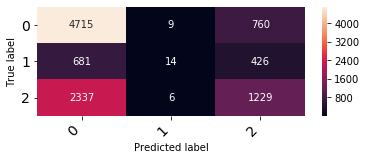

              precision    recall  f1-score   support

           0       0.61      0.86      0.71      5484
           1       0.48      0.01      0.02      1121
           2       0.51      0.34      0.41      3572

    accuracy                           0.59     10177
   macro avg       0.53      0.41      0.38     10177
weighted avg       0.56      0.59      0.53     10177



In [496]:
# pipeline.score(X_train,y_train)
generate_results(pipeline,X_test,y_test)